In [21]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
%matplotlib inline

In [22]:
boston = pd.read_csv('results_2014.csv')
print(boston.head())
print(boston.info())
print(boston.ctz.unique())

     10k                name  division    25k gender  age  official bib  \
0  17.37  Yamamoto, Hiroyuki         8  47.67      M   47     85.25  W1   
1  32.58        Jeptoo, Rita         1  82.43      F   33    138.95  F1   
2  16.62   Van Dyk, Ernst F.         1  45.80      M   41     80.60  W2   
3  32.57        Dibaba, Mare         3  82.43      F   24    140.58  F2   
4  17.12      Hokinoue, Kota         2  46.37      M   40     81.23  W3   

   genderdiv  ctz   ...   overall  pace  state    30k     5k   half    20k  \
0          8  NaN   ...         8  3.27    NaN  59.18   8.02  39.72  37.65   
1          1  NaN   ...        21  5.30    NaN  99.33  16.22  69.47  65.83   
2          1  NaN   ...         1  3.08    NaN  56.45   7.75  38.03  36.10   
3          3  NaN   ...        27  5.37    NaN  99.33  16.20  69.47  65.83   
4          2  NaN   ...         2  3.10    NaN  57.03   8.02  38.60  36.58   

  country            city     40k  
0     JPN         Fukuoka   80.43  
1     KE

In [23]:
boston = boston.replace(to_replace='-', value=0)
boston['gender'] = np.where(boston['gender'] == 'M', 1, 0)

columns = ['10k','25k','gender','35k','30k','5k','half','20k','40k']
for column in columns:
    boston[column] = boston[column].astype('float64')

#dummies = ['ctz','bib','state','city','country']
#for dum in dummies:
#    boston = pd.concat([boston,pd.get_dummies(boston[dum])], axis=1)

print(boston.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null float64
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null float64
gender       31984 non-null float64
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null float64
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null float64
5k           31984 non-null float64
half         31984 non-null float64
20k          31984 non-null float64
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null float64
dtypes: float64(11), int64(4), object(6)
memory usage: 5.1+ MB
None


In [24]:
boston = boston.drop(['ctz','bib','state','city','country','name'],axis=1)

          10k  division     25k  gender  age  official  genderdiv     35k  \
22197  102.82      2475  289.02     1.0   52    538.88      17575  439.82   
28230   94.45      5911  281.85     1.0   36    534.22      17574  449.33   
29525   89.55      2474  259.08     1.0   52    479.80      17573  391.60   
22164   84.32      1112    0.00     1.0   64    473.17      17572  377.67   
22307   95.77      2297    0.00     0.0   47    472.57      14356    0.00   

       overall   pace     30k     5k    half     20k     40k  
22197    31931  20.57  367.20  46.47  236.67  224.35  508.17  
28230    31930  20.38  376.38  40.75  222.07  211.75  508.35  
29525    31929  18.30  324.15  44.95  211.25  199.92  455.97  
22164    31928  17.37  311.38  40.78  202.22  189.23    0.00  
22307    31927  17.30  322.28  43.10  213.68  202.07    0.00  


In [26]:
boston = boston.sort_values(by=['overall'], ascending=True)
boston_500 = boston[0:500]
print(len(boston_500))

500


In [27]:
# Define the features and the outcome.
X = boston_500.drop(['gender'],axis=1)
#X = X.dropna()
y = boston_500['gender'] #age, country, etc

# Normalize the data.
X_norm = normalize(X)

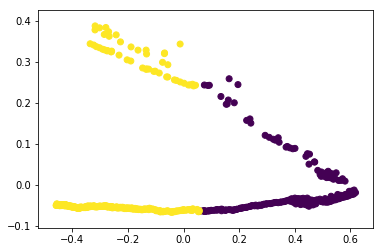

In [28]:
# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=1337).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
#print('Comparing k-means clusters against the data:')
#print(pd.crosstab(y_pred, y))

In [29]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=200)
minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_pca)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_pred))

Comparing k-means and mini batch k-means solutions:
col_0    0    1
row_0          
0        1  299
1      200    0


In [30]:
#Divide into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_pca,
    y,
    test_size=0.9,
    random_state=42)

In [31]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))


Number of estimated clusters: 5


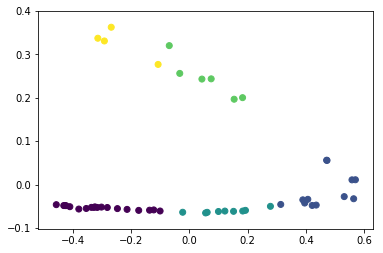

Comparing the assigned categories to the ones in the data:
col_0    0   1  2  3  4
gender                 
0.0      0   2  0  2  0
1.0     19  10  9  4  4


In [32]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,labels))

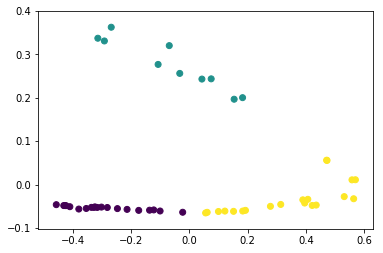

Comparing the assigned categories to the ones in the data:
col_0    0  1   2
gender           
0.0      0  2   2
1.0     20  8  18


In [33]:
from sklearn.cluster import SpectralClustering

# We know we're looking for three clusters.
n_clusters=3

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train)

#Predicted clusters.
predict=sc.fit_predict(X_train)

#Graph results.
plt.scatter(X_train[:, 0], X_train[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,predict))

In [34]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
af = AffinityPropagation().fit(X_train)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

Done
Estimated number of clusters: 6


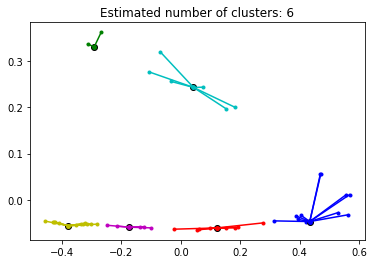

In [35]:
from itertools import cycle

plt.figure(1)
plt.clf()

# Cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster.
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_train[cluster_centers_indices[k]]
    plt.plot(X_train[class_members, 0], X_train[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_train[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()

In [36]:
# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=42).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

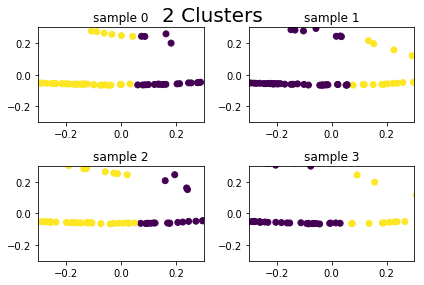

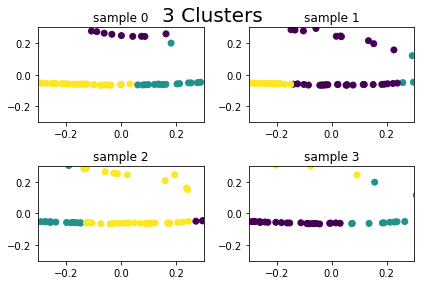

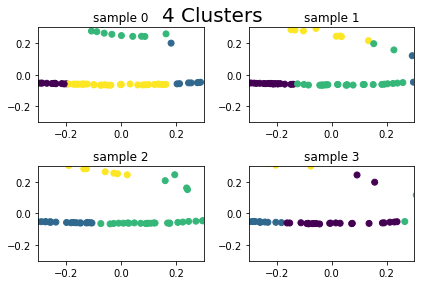

In [37]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

In [38]:
# Get predicted clusters.
full_pred = KMeans(n_clusters=2, random_state=1337).fit_predict(X_norm)

pd.crosstab(y, full_pred) 

col_0,0,1
gender,,
0.0,38,3
1.0,163,296


In [39]:
# Note: the itertools module is tons of fun and very useful.
import itertools

# Create a list of pairs, where each pair is the ground truth group
# and the assigned cluster.
c = list(itertools.product(y, full_pred))

In [40]:
# Count how often each type of pair (a, b, c, or d) appears.
RIcounts = [[x, c.count(x)] for x in set(c)]
print(RIcounts)

[[(0.0, 1), 12259], [(1.0, 0), 92259], [(0.0, 0), 8241], [(1.0, 1), 137241]]


In [41]:
len(c)

250000

In [42]:
# Create the same counts but without the label, for easier math below.
RIcounts_nolabel = [c.count(x) for x in set(c)]

In [43]:
# Calculate the Rand Index.
RIscore = (RIcounts_nolabel[3] + RIcounts_nolabel[2]) / np.sum(RIcounts_nolabel)
print(RIscore)

0.581928


In [44]:
from sklearn import metrics
    
metrics.adjusted_rand_score(y, full_pred)

0.08787736753452507

In [45]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances

for sample in [X1, X2, X3, X4]:
    model = KMeans(n_clusters=2, random_state=42).fit(sample)
    labels = model.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

0.5401858745257228
0.5944829938752141
0.5950379821276248
0.6312101650396795
